# Intro to HPC: Solar Cell project

Project: Solar Power for Affordable Housing through Computational Design of Low-Cost/High-Efficiency Solar Cells.
Author: AlvaroVM [https://alvarovm.github.io](http://alvarovm.github.io)

Version: 0.0.2

## Part 6 Machine Learning with Gaussian Process Regression 

In this notebook we will use Gaussian Process Regression (GPR) to predict molecular optical activity, particularly to predict the spectral peak that corresponds to the first excitation energy. In this exercise we will need to the DyeDB and the data we agregated in previous notebooks.

We would use GPR algorithm implemented in the GPflow code. This implementation relies on Tensorflow, which is a popular package for artificial intelligence and is portable among different computer architectures. Tensorflow could use GPUs and accelerate regression and inference. One advantage of fast regression is that we could optimize hyper parameters and create models that fit better the data.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs 
from rdkit.Chem import Draw
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem.Draw import IPythonConsole
print(f'        RDkit version : {rdkit.__version__}')

from tqdm.autonotebook import tqdm

from collections import OrderedDict

# utils
from collections import OrderedDict
from tqdm.autonotebook import tqdm
# scientific python

#import seaborn as sns
import sklearn
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.ensemble
import scipy.stats

import tensorflow as tf
print(f'   Tensorflow version : {tf.__version__}')
print("{} GPU(s) recognized by tensorflow:".format(len(tf.config.list_physical_devices('GPU'))), tf.config.list_physical_devices('GPU'))


import gpflow
from gpflow.utilities import print_summary
print(f'       GPflow version : {gpflow.__version__}')
tqdm.pandas()


        RDkit version : 2023.03.2


/tmp/ipykernel_2027900/2575822876.py:16: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
2025-08-14 15:24:42.515813: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-14 15:24:47.420288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


   Tensorflow version : 2.13.0
1 GPU(s) recognized by tensorflow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
       GPflow version : 2.8.1


#### Test GPU 

In [ ]:
# This cell gives us a couple options for debugging Tensorflow.
# It is the first code cell, because it must be run, before the TensorFlow library is imported and it is most convenient to import all modules in the next cell
# To enable this debugging, you must change one of the debugging flags to True and run this cell *before* importing running later cells
# Currently this is only done manually from the notebook, but could be included as a JSON setting in the future if desirable

# import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
#export CUDA_VISIBLE_DEVICE=
#export CUDA_VISIBLE_DEVICE=0
#export CUDA_VISIBLE_DEVICE=0,1

# Disable GPUS
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# print(f'   Tensorflow version : {tf.__version__}')
# print("{} GPU(s) recognized by tensorflow:".format(len(tf.config.list_physical_devices('GPU'))), tf.config.list_physical_devices('GPU'))


In [2]:
def rmse(pred, target):
    """
    Input Args:
    pred: predictions numpy array
    target :True label numpy array
    return : rmse 
    """
    return np.sqrt(((pred - target) ** 2).mean())

In [3]:
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem.rdMolDescriptors import  GetHashedMorganFingerprint,GetMorganFingerprintAsBitVect


from rdkit.Chem import MolFromSmiles as smi2mol
def canon_smiles(smi):
    try:
        m = smi2mol(smi)
        if m is None:
            #print('hola'+smi)
            return False
        else:
            return Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
    except:
        return False
    
def applyMorganFP(m,**kwargs):
    fptype='bit'
    
    if 'fptype' in kwargs:
        fptype=kwargs['fptype']
    if 'fp_args' in kwargs:
        fp_args=kwargs['fp_args']     
    #fp_args = self.meta_data['fp_args']
    #fptype = self.meta_data['fptype']
    arr = np.zeros((1,))
    if fptype == 'bit': 
        arr = np.zeros((1,))
        #ConvertToNumpyArray(GetHashedMorganFingerprint(m, **fp_args), arr)
        try:
            arr = np.array(GetMorganFingerprintAsBitVect(m, **fp_args))
        except:
            print(Chem.MolToSmiles(m))
    elif fptype == 'count':
        #arr = np.zeros((1,))
        ConvertToNumpyArray(GetHashedMorganFingerprint(m, **fp_args), arr)
    return arr

### Load data

In [5]:
df = pd.read_pickle('my_dataframe.pkl').fillna(value = 0)
print('Column names: {}'.format(str(df.columns.tolist())))
print('Table Shape: {}'.format(df.shape))
#df.head(2)

Column names: ['inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nostda', 'smiles', 'mol', 'morgan_fp_array', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'valid_smi', 'cannon_smiles', 'gap_mopac', 'gap_zindo', 'gap_dft']
Table Shape: (5660, 49)


### Clean data

In [6]:
#df=df[df['lambda_tddft (nm)']>0]
df=df[df['lambda_sTDA (nm)']>0]
#df=df[df['cluster']>-1]
print('Table Shape: {}'.format(df.shape))

Table Shape: (5660, 49)


### Sample randomly a faction of the data and reset indexes

In [7]:
df = df.sample(n=1000, replace=True, random_state=1)
df = df.reset_index()

In [8]:
df.head()

,index,inchikey,smi_pre,smi_post,lambda_sTDA (nm),f1_sTDA,lumo_dft,homo_dft,dmom_dft (D),lambda_z (nm),...,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,valid_smi,cannon_smiles,gap_mopac,gap_zindo,gap_dft
0,8935,YUDVHLAMTRTFDC-VVHMCBODSA-N,OC[C@H]1O[C@H]([C@@H]([C@@H]1O)O)n1c2ccc(cc2c2...,OC[C@H]1O[C@H]([C@@H]([C@@H]1O)O)n1c2ccc(cc2c2...,294.2,0.080234,-0.2163,-8.5046,1.21417,321.535784,...,3,0,1,1,144,True,OC[C@H]1O[C@H]([C@@H]([C@@H]1O)O)n1c2ccc(cc2c2...,7.863,7.4814,8.2883
1,373,GZMPURGRPFOJMG-UHFFFAOYSA-N,CCCCC(COc1cc(C=Cc2ccc(cc2)OC)c(cc1C=Cc1ccc(cc1...,C(COc1cc(C=Cc2ccc(cc2)OC)c(cc1C=Cc1ccc(cc1)OC)...,351.3,2.015994,0.1360,-6.9456,1.56888,333.022290,...,20,0,0,0,238,True,CCCCC(COc1cc(C=Cc2ccc(cc2)OC)c(cc1C=Cc1ccc(cc1...,7.451,7.2298,7.0816
2,5228,HCCOOGWHEHRKPQ-UHFFFAOYSA-N,COc1ccccc1C(CC(=O)C)O,COc1ccccc1C(CC(=O)C)O,262.4,0.000577,1.4699,-8.4554,4.85162,331.508552,...,4,0,0,0,76,True,COc1ccccc1C(CC(=O)C)O,9.178,8.7226,9.9253
3,8989,MLRDHYHIGKWOKE-UHFFFAOYSA-N,CCOC(=O)c1c(N)sc2c1c1ccccc1C2=Cc1ccc(cc1)C#N,CCOC(=O)c1c(N)sc2c1c1ccccc1C2=Cc1ccc(cc1)C#N,407.0,0.167684,-0.6600,-7.4398,5.78557,435.032275,...,3,0,0,0,132,True,CCOC(=O)c1c(N)sc2c1c1ccccc1C2=Cc1ccc(cc1)C#N,7.157,6.5014,6.7798
4,1361,QJVIEHMBGFEVQI-UHFFFAOYSA-N,CCC(=O)N1CC2CCCC(C1)N2CC=C(c1ccccc1)C,C(=O)N1CC2C(C1)N2CC=C(c1ccccc1)C,233.7,0.016594,1.3273,-8.9145,5.42059,291.521746,...,4,0,2,2,124,True,CCC(=O)N1CC2CCCC(C1)N2CC=C(c1ccccc1)C,9.204,9.1378,10.2418


In [9]:
getonly=['NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
                           'NumAliphaticHeterocycles', 'NumAliphaticRings',
                           'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
                           'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 
                           'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
                           'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 
                           'NumSaturatedRings', 'NumValenceElectrons',
'qed','TPSA', 'MolLogP', 'MolMR','BalabanJ', 'BertzCT',
'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO',
                            'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 
                            'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine',
                            'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1',
                            'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde',
                            'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide',
                            'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo',
                            'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic',
                            'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether',
                            'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 
                            'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone',
                            'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine',
                            'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 
                            'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 
                            'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 
                            'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd',
                            'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
                            'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 
                            'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea',
                            'MolWt','MolLogP']
getonly=['NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
                           'NumAliphaticHeterocycles', 'NumAliphaticRings',
                           'NumAromaticCarbocycles', 'NumAromaticHeterocycles',
                           'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 
                           'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds',
                           'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 
                           'NumSaturatedRings', 'NumValenceElectrons',
                            ]

In [ ]:
# import inspect
# import rdkit.Chem.Descriptors as Descriptors


# calc_props = OrderedDict(inspect.getmembers(Descriptors, inspect.isfunction))
# for key in list(calc_props.keys()):
#     if key.startswith('_'):
#         del calc_props[key]
#     else:
#         thisnot=False
#         for myprop in getonly:
#             if myprop == key:
#                 thisnot=True
#         if not thisnot:
#             del calc_props[key]


# def calc_all(df,calc_props,smiles_col='smiles'):
#     df['mol'] = df[smiles_col].apply(Chem.MolFromSmiles)
#     for key,val in calc_props.items():
#         df[key] = df['mol'].apply(val)
#         #df[key] = df['mol'].swifter.apply(val)
#     return df
# print('Found {} molecular descriptors in RDKIT'.format(len(calc_props)))
# #calc_props

In [10]:
#from gpmol.features.fingerprint_features import canon_smiles
#from gpmol.features.fingerprints3D_features import geo3d_sanity_check
#from gpmol.utils.mol import canon_smiles



print('Before properties: {}'.format(str(df.columns.tolist())))
#df = geo3d_sanity_check(df)
#df['smiles'] = df['smi'].apply(canon_smiles)
#df['smiles'] = df['SMI']
#calc_all(df,calc_props)
#df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
#df['morganfps']=df['mol'].apply(applyMorganFP,fp_args={'radius':4, 'nBits':2048})
#print(df.shape)
#df.head(1)

Before properties: ['index', 'inchikey', 'smi_pre', 'smi_post', 'lambda_sTDA (nm)', 'f1_sTDA', 'lumo_dft', 'homo_dft', 'dmom_dft (D)', 'lambda_z (nm)', 'f1_z', 'lumo_z', 'homo_z', 'dmom_z (D)', 'lumo_mopac', 'homo_mopac', 'dmom_mopac (D)', 'lambda_tddft (nm)', 'f1_tddft', 'lambda_exp_max (nm)', 'epsilon_exp_max ', 'lambda_exp_min (nm)', 'epsilon_exp_min ', 'solvent', 'nostda', 'smiles', 'mol', 'morgan_fp_array', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'valid_smi', 'cannon_smiles', 'gap_mopac', 'gap_zindo', 'gap_dft']


In [ ]:
#calc_all(df,calc_props)
#print('After properties: {}'.format(str(df.columns.tolist())))

### Define tools for feature selection

In [11]:
def rf_feature_mask(x, y, k):
   rf = sklearn.ensemble.RandomForestRegressor()
   rf.fit(x,y)
   indices = (-rf.feature_importances_).argsort()[:k]
   mask = np.zeros_like(rf.feature_importances_)
   mask[indices] = 1.0
   return mask.astype(bool)

class IdentityTransformer(sklearn.preprocessing.FunctionTransformer):
    
    def __init__(self):
        super().__init__(lambda x:x, lambda x:x)

class GPFeature():
    
    def __init__(self, label, x, y, n_features=None, preproc=None):
        self.label = label
        n_features = n_features or x.shape[-1]
        x_feats = x.shape[-1]
        if n_features > x_feats:
            raise ValueError(f'n_features={n_features} larger than x.shape[-1] {x_feats}')
        elif n_features < x_feats:
            mask = rf_feature_mask(x, y, n_features)
        else:
            mask = np.ones(x_feats).astype(bool)
        self.mask = mask
        preproc = preproc or IdentityTransformer()
        self.preproc = preproc.fit(x[:,self.mask])
        self.ndim = sum(self.mask)
        self.active_dims = np.arange(self.ndim)
    
    def transform(self, x):
        return self.preproc.transform(x[:,self.mask]).astype(np.float64)
    
def evaluate_result(y_true, y_pred, fold=None):
    result = OrderedDict()
    result['r2'] = sklearn.metrics.r2_score(y_true,y_pred)
    result['rmse'] = np.sqrt(sklearn.metrics.mean_squared_error(y_true,y_pred))
    result['mae'] = np.sqrt(sklearn.metrics.mean_absolute_error(y_true,y_pred))
    result['r'] = scipy.stats.pearsonr(y_test.ravel(),y_pred.ravel())[0]
    if fold:
        result['cv'] = fold
    return result

#### Train/Test split

In [12]:
indices=df.index.tolist()
train_index,test_index = sklearn.model_selection.train_test_split(indices, test_size=.30)
print(len(train_index),len(test_index))

700 300


#### Standarize data

In [13]:
target='lambda_sTDA (nm)'
y_true = df[target].values.reshape(-1,1).astype(np.float64)
y_preproc = sklearn.preprocessing.StandardScaler()
y_train = y_preproc.fit_transform(y_true[train_index])
y_test = y_true[test_index]
print(y_train.shape, y_test.shape)

(700, 1) (300, 1)


#### Select fingerprint and select the most relevant features that will be used for training

In [15]:

fp = np.vstack(df['morgan_fp_array'])
print(fp.shape)
#n_features = 200
fp_feat = GPFeature('fp', fp[train_index], y_train, 200)
fp_train = fp_feat.transform(fp[train_index]) 
fp_test = fp_feat.transform(fp[test_index]) 
print(fp_train.shape,fp_test.shape)

(1000, 2048)


/tmp/ipykernel_2027900/2958483818.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x,y)


(700, 200) (300, 200)


#### Select Properties

In [16]:
other_features = getonly
x_tmp = df[other_features].values
#n_features = 4
chem_feat = GPFeature('chemoinformatic', x_tmp[train_index],y_train, 4, sklearn.preprocessing.StandardScaler())
chem_train = chem_feat.transform(x_tmp[train_index])
chem_test = chem_feat.transform(x_tmp[test_index])
print(chem_train.shape,chem_test.shape)

/tmp/ipykernel_2027900/2958483818.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x,y)


(700, 4) (300, 4)


#### Combine fingerprint and descriptors

In [17]:
x_train = np.hstack((fp_train,chem_train))
x_test = np.hstack((fp_test,chem_test))
print(x_train.shape,x_test.shape)

(700, 204) (300, 204)


### GP regression

#### Building Kernel

In [18]:
last_dim = 0
fp_kernel = gpflow.kernels.RBF(active_dims=fp_feat.active_dims+last_dim)
last_dim  = fp_kernel.active_dims[-1]+1
chem_kernel = gpflow.kernels.RBF(active_dims=chem_feat.active_dims+last_dim)
kernel = fp_kernel + chem_kernel
print_summary(kernel)

2025-08-14 15:27:54.048377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0


╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───

#### Specify kernel

In [19]:
model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)

#### Optimize model

In [20]:
opt = gpflow.optimizers.Scipy()

def objective():
    return - model.log_marginal_likelihood()

opt_logs = opt.minimize(objective,
                        model.trainable_variables,
                        options=dict(maxiter=500))
print_summary(model)

2025-08-14 15:28:03.047708: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x556762ec1d80


╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.90991 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.03073 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 3.81837 │
├───────

#### Predict and scale (inverse), print statistics of the model

In [21]:

y_pred, y_std  = model.predict_y(x_test)
y_pred = y_preproc.inverse_transform(y_pred.numpy())
results = [evaluate_result(y_test, y_pred)]
pd.DataFrame(results)

,r2,rmse,mae,r
0,0.655158,33.328795,4.819296,0.810206


#### Plot the comparison between predicted and true

Text(0.5, 1.0, 'GPR lambda_sTDA (nm)')

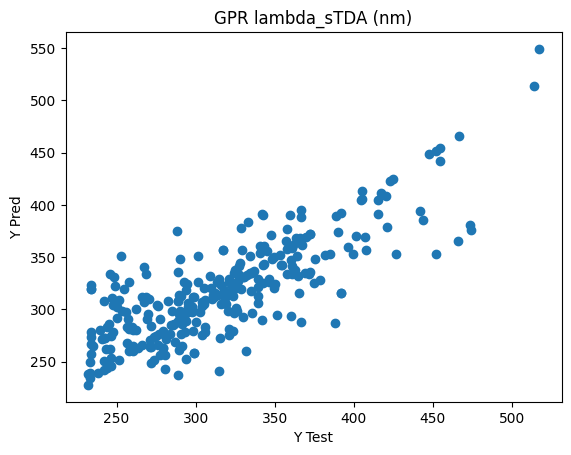

In [22]:
plt.scatter(y_test,y_pred)
plt.xlabel('Y Test')
plt.ylabel('Y Pred')
plt.title(f"GPR {target}")